# SFig.2 — Polynomial (2nd) Fitting of Monthly Tide Levels

This notebook builds a concise supplement figure comparing linear vs. 2nd-order polynomial fits on monthly tide gauge records. It computes RMSE and average SLR (cm/yr) from fitted series and exports a figure and a metrics table.

In [7]:
# Imports and setup
import os
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

DATA_DIR = Path('Data')
OUTPUT_DIR = Path('Output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def load_monthly_txt(path: Path) -> pd.DataFrame:
    """
    Parse PSMSL-like monthly file with columns: YYYY MM DD hh mm  value
    Returns DataFrame with columns: date (datetime), value (float)
    """
    rows = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for ln in f:
            ln = ln.strip()
            if not ln:
                continue
            parts = ln.split()
            try:
                y, mo, d, hh, mm = map(int, parts[:5])
                val = float(parts[-1])
            except Exception:
                # Skip header or malformed lines
                continue
            rows.append((datetime(y, mo, d, hh, mm), val))
    df = pd.DataFrame(rows, columns=['date', 'value']).sort_values('date').reset_index(drop=True)
    return df

def load_all_monthly(data_dir: Path = DATA_DIR) -> dict:
    out = {}
    for p in sorted(data_dir.glob('Monthly_*.txt')):
        name = p.stem.replace('Monthly_', '')
        out[name] = load_monthly_txt(p)
    return out

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def fit_linear(dates, values):
    x = mdates.date2num(pd.to_datetime(dates))
    y = np.asarray(values, dtype=float)
    c = np.polyfit(x, y, deg=1)
    f = np.poly1d(c)
    yhat = f(x)
    _rmse = rmse(y, yhat)
    years = (pd.to_datetime(dates).iloc[-1] - pd.to_datetime(dates).iloc[0]).days / 365.0
    ave_slr = float((yhat[-1] - yhat[0]) / years) if years > 0 else np.nan
    return {
        'coef': c, 'pred': yhat, 'rmse': _rmse, 'ave_slr_cm_per_yr': ave_slr
    }

def fit_quadratic(dates, values):
    x = mdates.date2num(pd.to_datetime(dates))
    y = np.asarray(values, dtype=float)
    c = np.polyfit(x, y, deg=2)
    f = np.poly1d(c)
    yhat = f(x)
    _rmse = rmse(y, yhat)
    years = (pd.to_datetime(dates).iloc[-1] - pd.to_datetime(dates).iloc[0]).days / 365.0
    ave_slr = float((yhat[-1] - yhat[0]) / years) if years > 0 else np.nan
    return {
        'coef': c, 'pred': yhat, 'rmse': _rmse, 'ave_slr_cm_per_yr': ave_slr
    }

monthly = load_all_monthly()
len(monthly), list(monthly.keys())[:5]  # quick peek


(21, ['Anheung', 'Boryeong', 'Busan', 'Chujado', 'Gadeokdo'])

## Plot: Linear vs 2nd-order polynomial fit

We compare fits for a few representative stations and annotate RMSE and average SLR over the record span.

In [8]:
# Choose stations for the panel figure (edit as needed)
default_panel = ['Busan', 'Incheon', 'Jeju', 'Gunsan', 'Mokpo', 'Sokcho']
panel = [s for s in default_panel if s in monthly]
panel


['Busan', 'Incheon', 'Jeju', 'Gunsan', 'Mokpo', 'Sokcho']

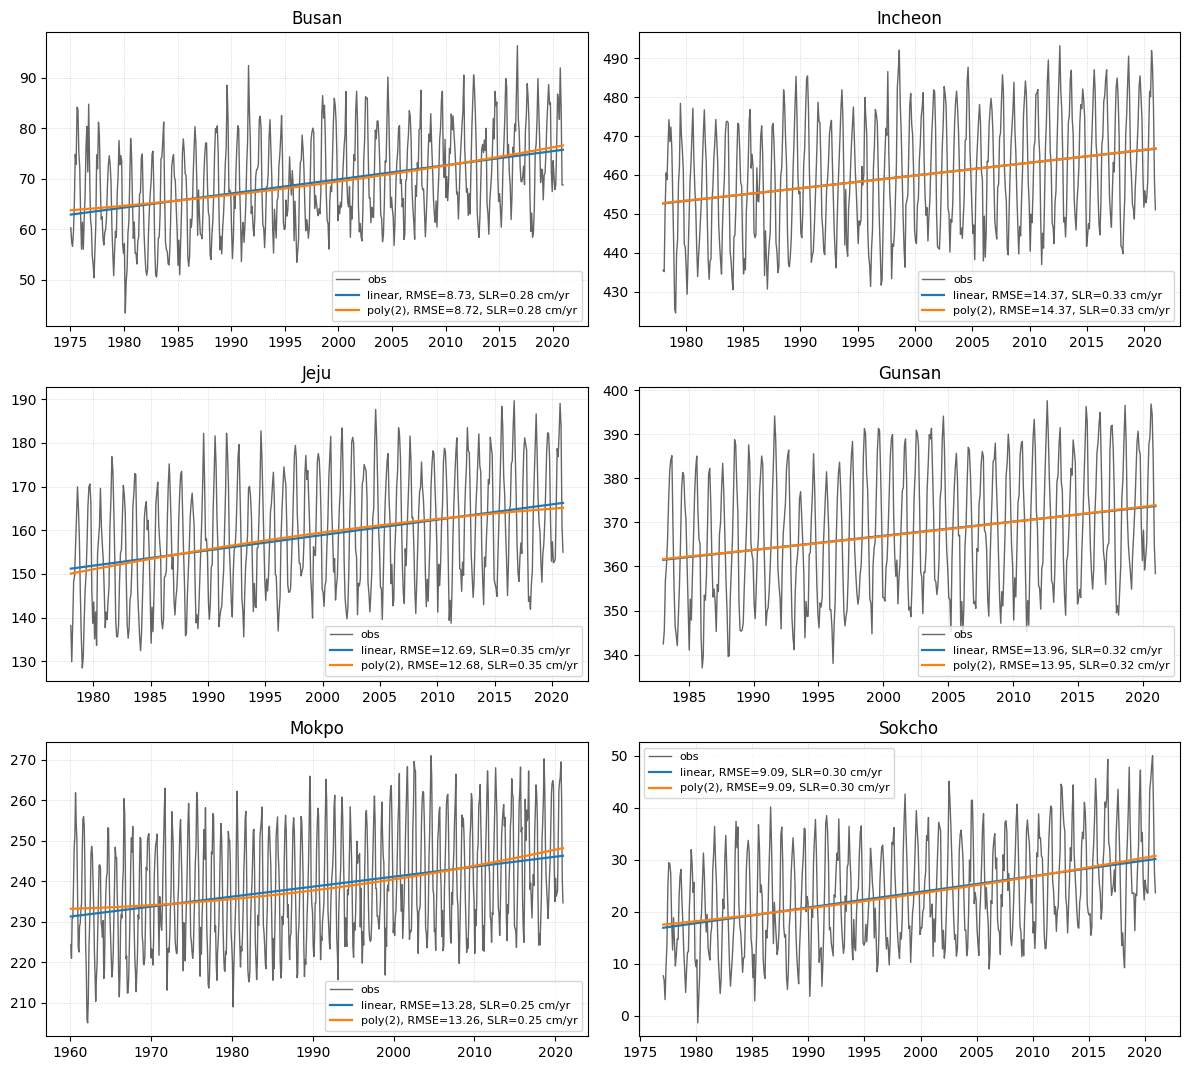

In [9]:
# Build the panel figure
n = len(panel)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 1.8*n), sharex=False)
axes = np.array(axes).reshape(nrows, ncols)

for i, name in enumerate(panel):
    r, c = divmod(i, ncols)
    ax = axes[r, c]
    df = monthly[name]
    lin = fit_linear(df['date'], df['value'])
    quad = fit_quadratic(df['date'], df['value'])

    ax.plot(df['date'], df['value'], color='k', lw=1.0, alpha=0.6, label='obs')
    ax.plot(df['date'], lin['pred'], color='tab:blue', lw=1.6, label=f"linear, RMSE={lin['rmse']:.2f}, SLR={lin['ave_slr_cm_per_yr']:.2f} cm/yr")
    ax.plot(df['date'], quad['pred'], color='tab:orange', lw=1.6, label=f"poly(2), RMSE={quad['rmse']:.2f}, SLR={quad['ave_slr_cm_per_yr']:.2f} cm/yr")

    ax.set_title(name)
    ax.grid(True, ls=':', lw=0.6, alpha=0.6)
    ax.legend(fontsize=8, loc='best')

# Hide any unused axes
for j in range(i+1, nrows*ncols):
    r, c = divmod(j, ncols)
    axes[r, c].axis('off')

fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'SFig2_polynomial_fitting.png', dpi=300, bbox_inches='tight')
fig.savefig(OUTPUT_DIR / 'SFig2_polynomial_fitting.pdf', bbox_inches='tight')
plt.show()


## Metrics per station

Compute RMSE and average SLR for linear vs. poly(2) across all available stations to support the discussion.

In [4]:
rows = []
for name, df in monthly.items():
    if len(df) < 6:  # too few points for quadratic
        continue
    lin = fit_linear(df['date'], df['value'])
    quad = fit_quadratic(df['date'], df['value'])
    rows.append({
        'station': name,
        'rmse_linear': lin['rmse'],
        'rmse_poly2': quad['rmse'],
        'slr_linear_cm_per_yr': lin['ave_slr_cm_per_yr'],
        'slr_poly2_cm_per_yr': quad['ave_slr_cm_per_yr'],
        'rmse_improvement_poly2_minus_linear': quad['rmse'] - lin['rmse']
    })
metrics = pd.DataFrame(rows).sort_values('rmse_improvement_poly2_minus_linear')
metrics.head()

metrics.to_csv(OUTPUT_DIR / 'SFig2_polynomial_metrics.csv', index=False)
OUTPUT_DIR / 'SFig2_polynomial_metrics.csv'


PosixPath('Output/SFig2_polynomial_metrics.csv')

In [5]:
metrics

,station,rmse_linear,rmse_poly2,slr_linear_cm_per_yr,slr_poly2_cm_per_yr,rmse_improvement_poly2_minus_linear
16,Ulleungdo,11.469956,11.347135,0.421301,0.421371,-0.122821
12,Pohang,8.993651,8.909023,0.306362,0.306412,-0.084629
10,Mokpo,13.283300,13.255835,0.245866,0.245877,-0.027465
4,Gadeokdo,10.179170,10.154637,0.265262,0.265292,-0.024533
13,Seogwipo,12.060726,12.044754,0.327049,0.327012,-0.015972
20,Yeosu,12.017118,12.005679,0.225492,0.225507,-0.011439
9,Jeju,12.689542,12.679271,0.350720,0.350701,-0.010271
2,Busan,8.732888,8.724400,0.279297,0.279308,-0.008488
19,Wido,12.941920,12.934950,0.341222,0.341196,-0.006970
14,Sokcho,9.089683,9.085549,0.300779,0.300790,-0.004134


### Notes
- Average SLR is computed as the difference of fitted endpoints divided by elapsed years.
- Polynomial fits may capture gentle curvature but should be interpreted cautiously; linear SLR remains the baseline metric.
- Edit `default_panel` to change stations included in the figure.